In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
!pip install tensorflow_decision_forests
import tensorflow as tf
import tensorflow_decision_forests as tfdf

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load a CSV file from Google Drive
file_path_test = '/content/drive/MyDrive/Adam Lee_ BUDT758J_Kaggle/Dataset/test.csv'
file_path_train = '/content/drive/MyDrive/Adam Lee_ BUDT758J_Kaggle/Dataset/train.csv'

In [ ]:
# Load the dataset
train_data = pd.read_csv(file_path_train)
test_data = pd.read_csv(file_path_test)
# Drop the 'Id' column from both train and test datasets
train_data.drop(columns=['Id'], inplace=True)


In [ ]:
train_data.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [ ]:
# Concatenate train and test data for preprocessing (excluding the target variable)
all_data = pd.concat([train_data.drop(columns=['SalePrice']), test_data], axis=0, ignore_index=True)

In [ ]:
# Data preprocessing
# Handle missing values
missing_values = all_data.isnull().sum().sort_values(ascending=False)
missing_values_percentage = (missing_values / len(all_data)) * 100
missing_data = pd.concat([missing_values, missing_values_percentage], axis=1, keys=['Total', 'Percentage'])
print("Missing Values:\n", missing_data.head(20))

Missing Values:
               Total  Percentage
PoolQC         2909   99.657417
MiscFeature    2814   96.402878
Alley          2721   93.216855
Fence          2348   80.438506
MasVnrType     1766   60.500171
Id             1460   50.017129
FireplaceQu    1420   48.646797
LotFrontage     486   16.649538
GarageFinish    159    5.447071
GarageQual      159    5.447071
GarageCond      159    5.447071
GarageYrBlt     159    5.447071
GarageType      157    5.378554
BsmtCond         82    2.809181
BsmtExposure     82    2.809181
BsmtQual         81    2.774923
BsmtFinType2     80    2.740665
BsmtFinType1     79    2.706406
MasVnrArea       23    0.787941
MSZoning          4    0.137033


In [ ]:
# Handle missing values for numerical features
numerical_features = ['LotFrontage', 'MasVnrArea', 'GarageYrBlt', 'BsmtFullBath']
for feature in numerical_features:
    all_data[feature] = all_data[feature].fillna(all_data[feature].median())

# Handle missing values for categorical features
categorical_features = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType',
                        'FireplaceQu', 'GarageQual', 'GarageCond', 'GarageFinish',
                        'GarageType', 'BsmtExposure', 'BsmtCond', 'BsmtQual',
                        'BsmtFinType2', 'BsmtFinType1', 'MSZoning']
for feature in categorical_features:
    all_data[feature] = all_data[feature].fillna(all_data[feature].mode()[0])

In [ ]:
# Data preprocessing

# Feature Engineering

# Polynomial Features
from sklearn.preprocessing import PolynomialFeatures

# Specify the degree of polynomial features
degree = 2

# Initialize PolynomialFeatures
poly = PolynomialFeatures(degree=degree, include_bias=False)

# Fit and transform the selected numerical features
poly_features = poly.fit_transform(all_data[['OverallQual', 'GrLivArea']])

# Print the shape of poly_features
print("Shape of poly_features:", poly_features.shape)

# Get the original feature names
original_feature_names = all_data[['OverallQual', 'GrLivArea']].columns

# Generate new feature names for polynomial features
poly_feature_names = poly.get_feature_names_out(input_features=['OverallQual', 'GrLivArea'])


# Print the length of poly_feature_names
print("Length of poly_feature_names:", len(poly_feature_names))

# Create a DataFrame with polynomial features
poly_df = pd.DataFrame(poly_features, columns=poly_feature_names)


Shape of poly_features: (2919, 5)
Length of poly_feature_names: 5


In [ ]:
# 2. Handling Categorical Variables
all_data = pd.get_dummies(all_data)

# 3. Handling Date/Time Features (if applicable)
all_data['YearBuilt'] = pd.to_datetime(all_data['YearBuilt']).dt.year

# 4. Combining Features
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

# 5. Binning/Discretization
all_data['LotAreaBin'] = pd.qcut(all_data['LotArea'], q=4, labels=False)

# Split back into train and test data
train_processed = all_data[:len(train_data)]
test_processed = all_data[len(train_data):]


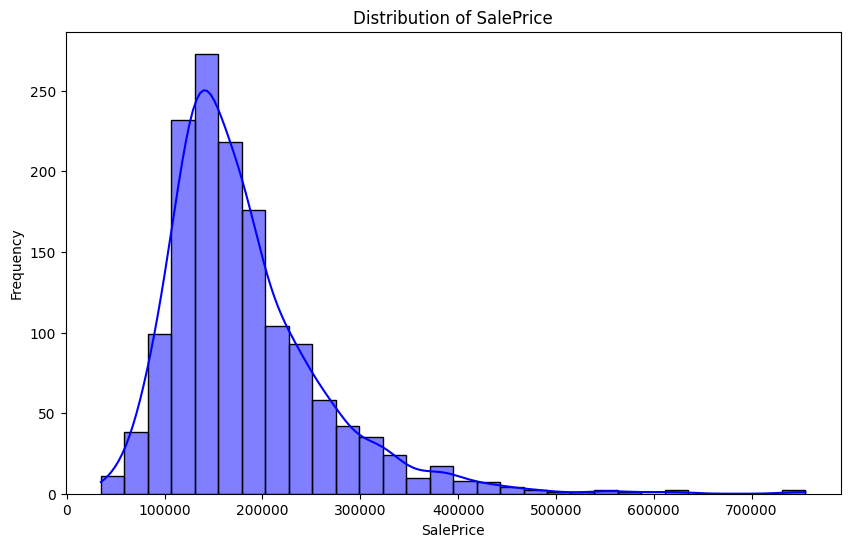

In [ ]:
# Exploratory Data Analysis (EDA)
# Visualize the distribution of the target variable (SalePrice)
plt.figure(figsize=(10, 6))
sns.histplot(train_data['SalePrice'], bins=30, kde=True, color='blue')
plt.title('Distribution of SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.show()

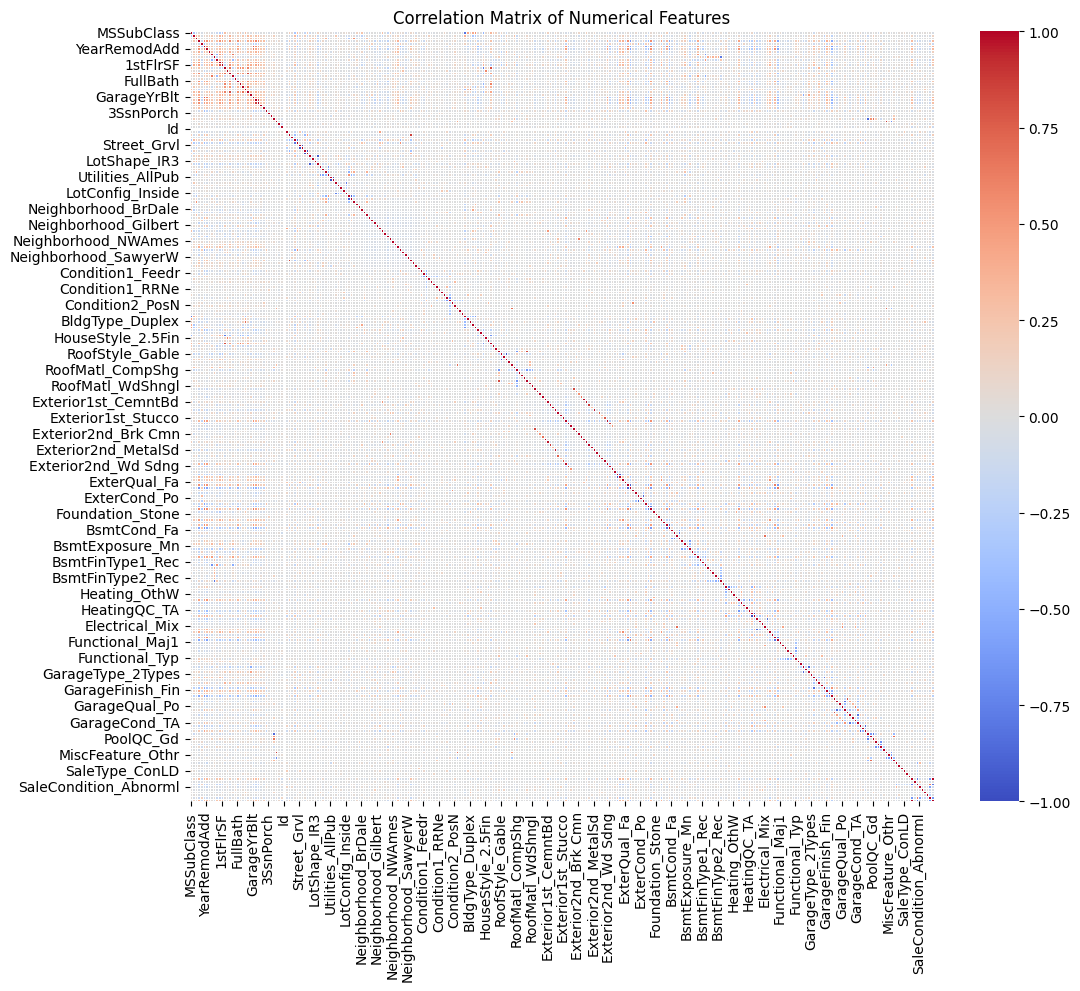

In [ ]:
# Visualize the correlation matrix of numerical features
plt.figure(figsize=(12, 10))
correlation_matrix = train_processed.corr()
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=False, linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()


<ipython-input-28-5b87453d9a1b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_processed['SalePrice'] = train_data['SalePrice']


Correlation with SalePrice:
 SalePrice           1.000000
OverallQual         0.790982
GrLivArea           0.708624
GarageCars          0.640409
GarageArea          0.623431
                      ...   
BsmtQual_TA        -0.498545
GarageFinish_Unf   -0.513906
KitchenQual_TA     -0.519298
ExterQual_TA       -0.589044
Id                       NaN
Name: SalePrice, Length: 289, dtype: float64


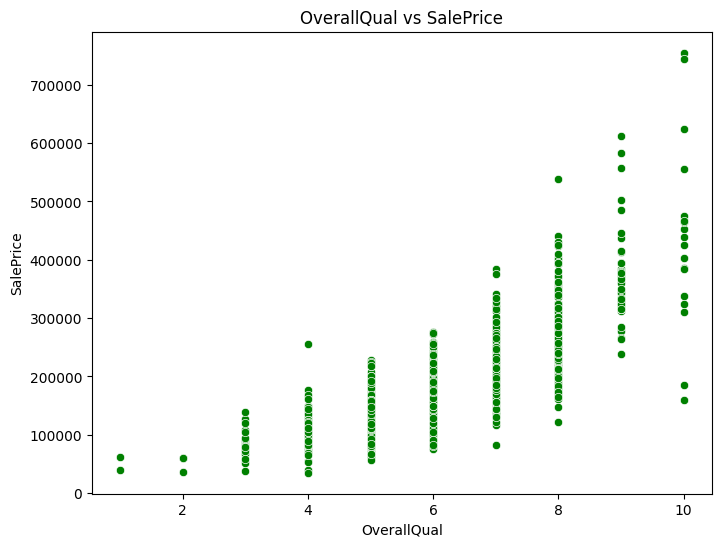

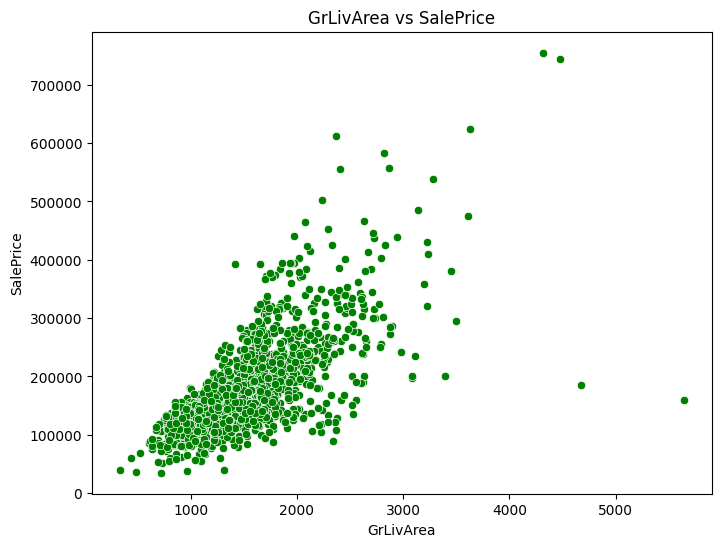

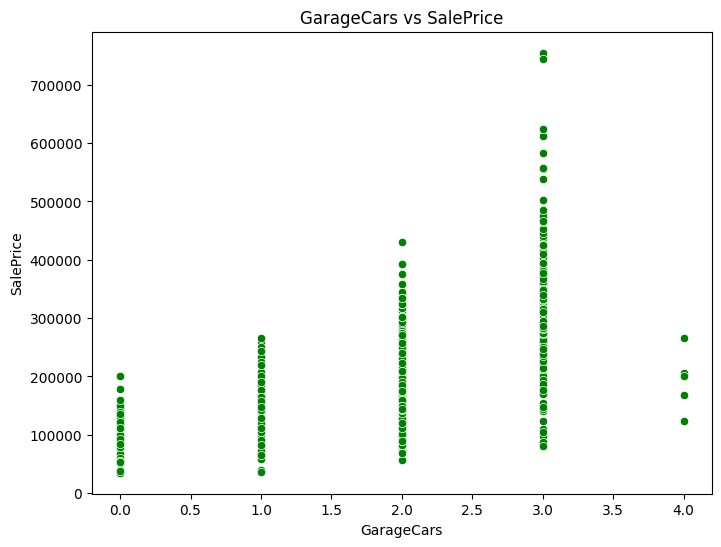

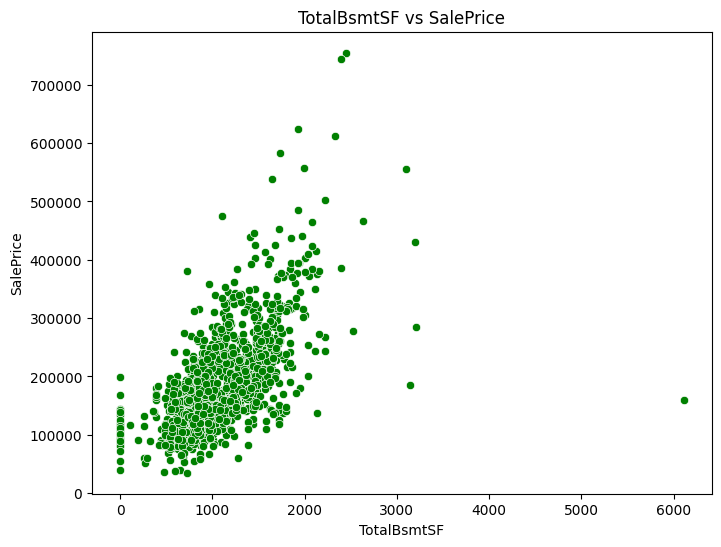

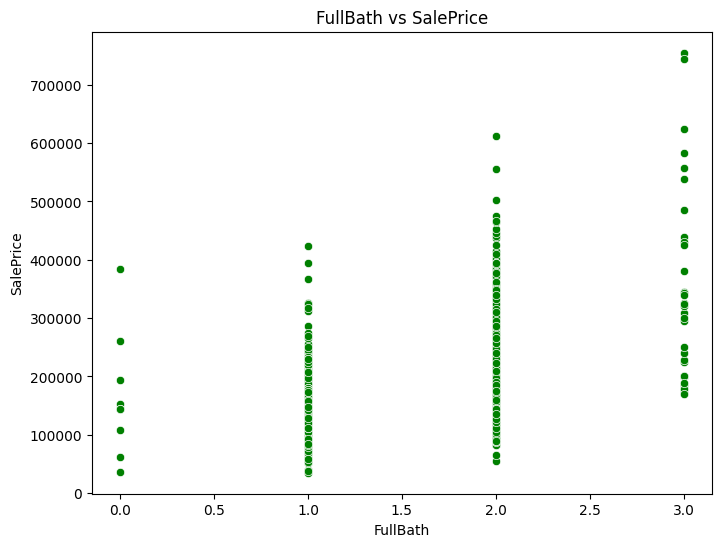

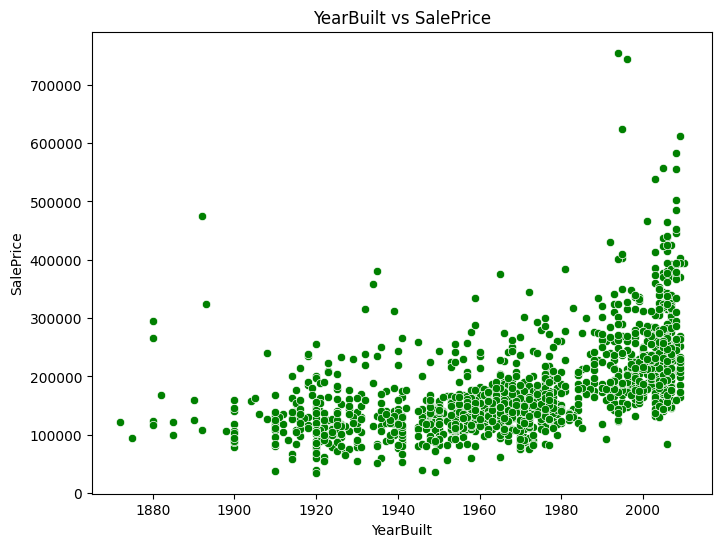

In [ ]:
# Concatenate 'SalePrice' column from train_data to train_processed
train_processed['SalePrice'] = train_data['SalePrice']
# Compute correlation matrix including 'SalePrice'
correlation_matrix = train_processed.corr()

# Investigate the correlation between features and the target variable
correlation_with_target = correlation_matrix['SalePrice'].sort_values(ascending=False)
print("Correlation with SalePrice:\n", correlation_with_target)

# Visualize the relationship between selected numerical features and the target variable
selected_features = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
for feature in selected_features:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=train_data[feature], y=train_data['SalePrice'], color='green')
    plt.title(f'{feature} vs SalePrice')
    plt.xlabel(feature)
    plt.ylabel('SalePrice')
    plt.show()

In [ ]:
list(set(train_data.dtypes.tolist()))

[dtype('O'), dtype('int64'), dtype('float64')]

In [ ]:
df_num = train_data.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


array([[<Axes: title={'center': 'MSSubClass'}>,
        <Axes: title={'center': 'LotFrontage'}>,
        <Axes: title={'center': 'LotArea'}>,
        <Axes: title={'center': 'OverallQual'}>,
        <Axes: title={'center': 'OverallCond'}>,
        <Axes: title={'center': 'YearBuilt'}>],
       [<Axes: title={'center': 'YearRemodAdd'}>,
        <Axes: title={'center': 'MasVnrArea'}>,
        <Axes: title={'center': 'BsmtFinSF1'}>,
        <Axes: title={'center': 'BsmtFinSF2'}>,
        <Axes: title={'center': 'BsmtUnfSF'}>,
        <Axes: title={'center': 'TotalBsmtSF'}>],
       [<Axes: title={'center': '1stFlrSF'}>,
        <Axes: title={'center': '2ndFlrSF'}>,
        <Axes: title={'center': 'LowQualFinSF'}>,
        <Axes: title={'center': 'GrLivArea'}>,
        <Axes: title={'center': 'BsmtFullBath'}>,
        <Axes: title={'center': 'BsmtHalfBath'}>],
       [<Axes: title={'center': 'FullBath'}>,
        <Axes: title={'center': 'HalfBath'}>,
        <Axes: title={'center': 'Bedroo

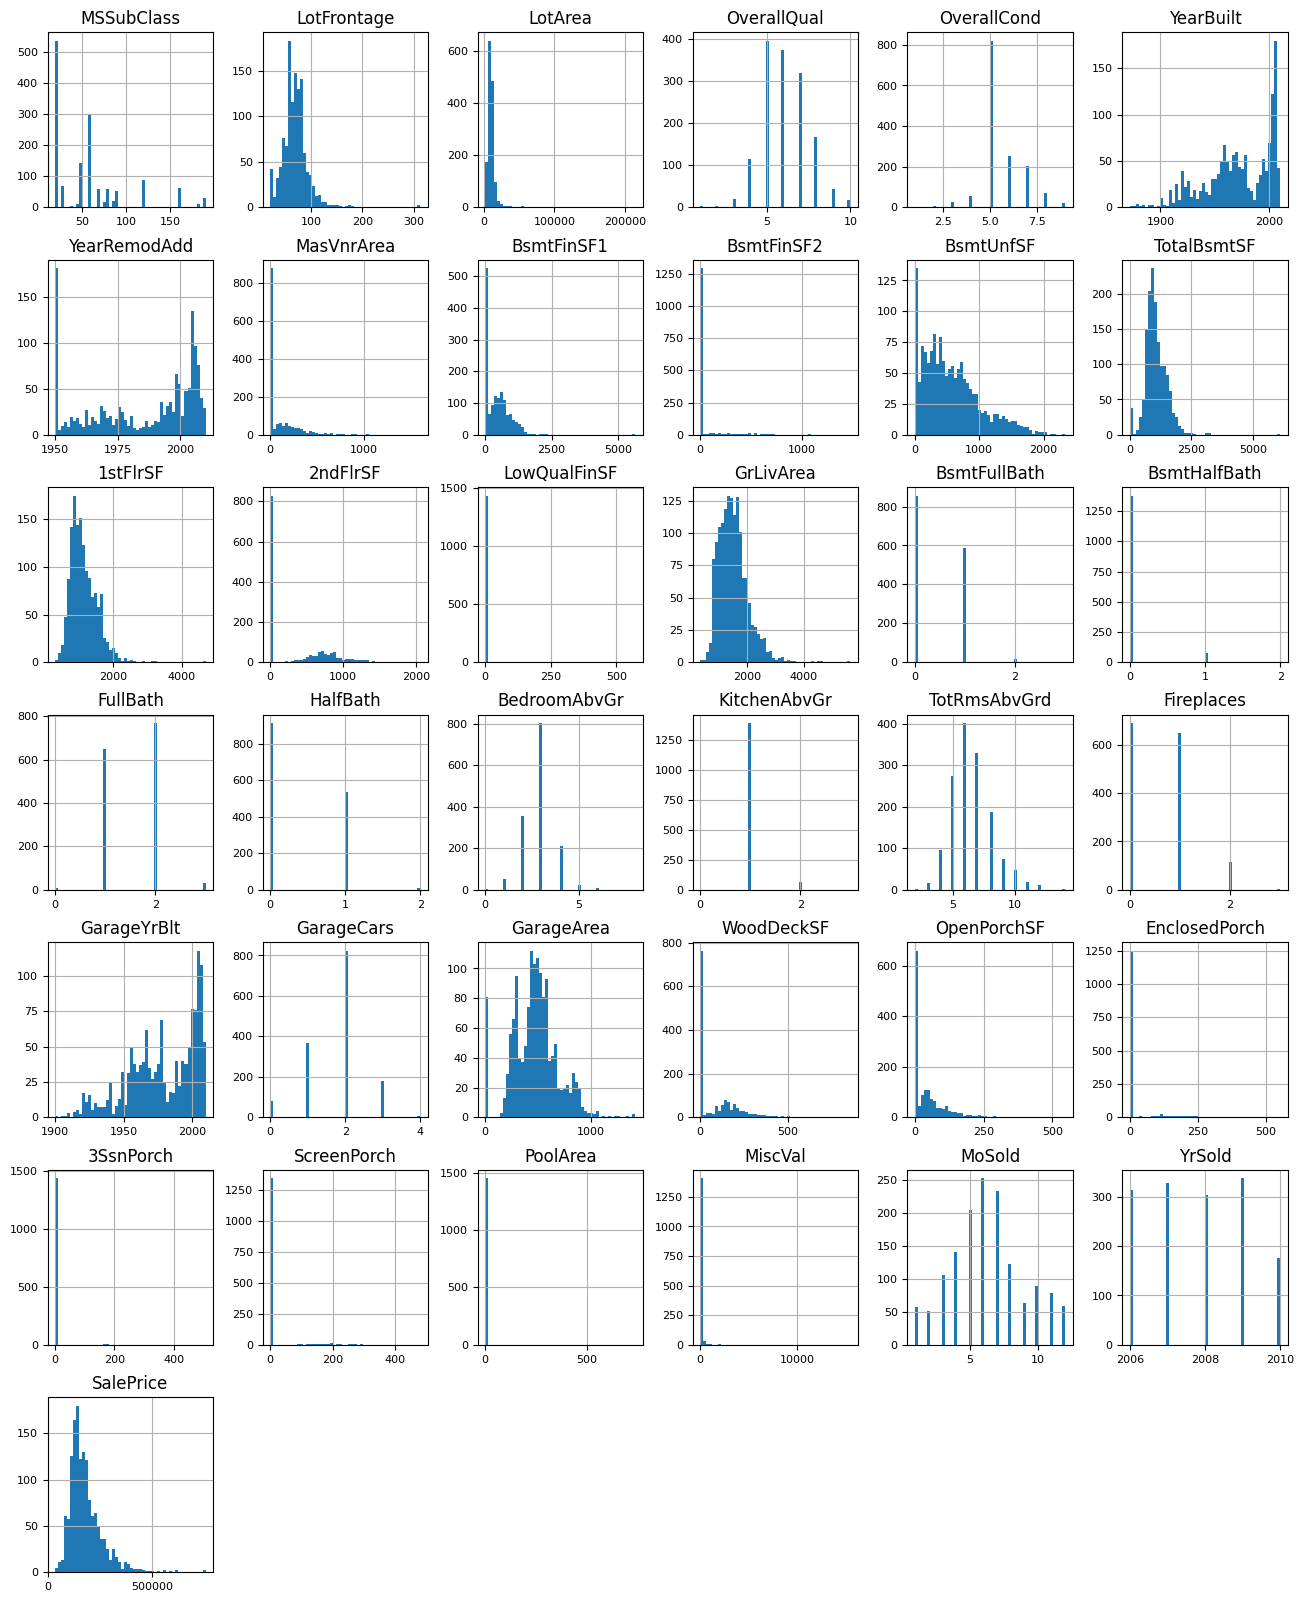

In [ ]:
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

In [ ]:
def split_dataset(dataset, test_ratio=0.30):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(train_data)
print("{} examples in training, {} examples in validation.".format(
    len(train_ds_pd), len(valid_ds_pd)))

1030 examples in training, 430 examples in validation.


In [ ]:
label = 'SalePrice'
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)

In [ ]:
#checking model availability
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

In [ ]:
# Hyperparameter Tuning


from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

from sklearn.impute import SimpleImputer

# Initialize SimpleImputer with a strategy (e.g., median)
imputer = SimpleImputer(strategy='median')

# Fit and transform the imputer on the concatenated data (including 'SalePrice')
all_data_imputed = imputer.fit_transform(all_data)

# Split back into train and test data
train_processed_imputed = all_data_imputed[:len(train_data)]
test_processed_imputed = all_data_imputed[:len(test_data)]


# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt'],
    'bootstrap': [True, False]
}

#param_grid = {
#    'n_estimators': [100, 150, 200],  # Reduced range
#    'max_depth': [None, 5, 10],        # Reduced range
#    'min_samples_split': [2, 3, 5],    # Reduced range
#    'min_samples_leaf': [1, 2, 3],     # Reduced range
#    'max_features': ['auto', 'sqrt'],
#    'bootstrap': [True, False]
#}

# Initialize the model
rf = RandomForestRegressor()

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)
#random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=50, cv=5, verbose=2, random_state=42, n_jobs=-1)


# Perform RandomizedSearchCV
# Takes a lot of time to run
random_search.fit(train_processed_imputed, train_data['SalePrice'])

# Get the best parameters
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# Get the best model
best_model = random_search.best_estimator_


Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best Parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': False}


In [ ]:
rf = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)

# Create a TensorFlow Decision Forests RandomForestModel with best parameters
best_rf_model = tfdf.keras.RandomForestModel(
    task=tfdf.keras.Task.REGRESSION,
    num_trees=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_examples=best_params['min_samples_split'],
    growing_strategy="BEST_FIRST_GLOBAL",
    categorical_algorithm="RANDOM"
)


best_rf_model.compile(metrics=["mse"])

Use /tmp/tmpgz0ga_5m as temporary training directory
Use /tmp/tmpfhinhgal as temporary training directory


In [ ]:
best_rf_model.fit(x=train_ds)

Reading training dataset...
Training dataset read in 0:00:01.112440. Found 1030 examples.
Training model...
Model trained in 0:00:02.090158
Compiling model...
Model compiled.


In [ ]:
tfdf.model_plotter.plot_model_in_colab(best_rf_model, tree_idx=0, max_depth=3)

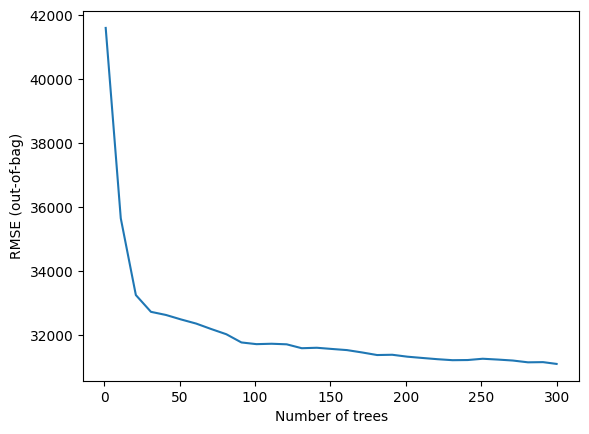

In [ ]:
logs = best_rf_model.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

In [ ]:
inspector = best_rf_model.make_inspector()
inspector.evaluation()

Evaluation(num_examples=1030, accuracy=None, loss=None, rmse=31112.433212059095, ndcg=None, aucs=None, auuc=None, qini=None)

In [ ]:
evaluation = best_rf_model.evaluate(x=valid_ds,return_dict=True)

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

1/1 [==============================] - 1s 1s/step - loss: 0.0000e+00 - mse: 1113236224.0000
loss: 0.0000
mse: 1113236224.0000


In [ ]:
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 SUM_SCORE
	 NUM_AS_ROOT
	 INV_MEAN_MIN_DEPTH
	 NUM_NODES


In [ ]:
inspector.variable_importances()["NUM_AS_ROOT"]

[("OverallQual" (1; #62), 106.0),
 ("ExterQual" (4; #22), 66.0),
 ("YearBuilt" (1; #76), 38.0),
 ("GrLivArea" (1; #38), 27.0),
 ("GarageCars" (1; #32), 18.0),
 ("KitchenQual" (4; #44), 13.0),
 ("BsmtQual" (4; #14), 10.0),
 ("TotalBsmtSF" (1; #73), 7.0),
 ("1stFlrSF" (1; #0), 6.0),
 ("GarageArea" (1; #31), 3.0),
 ("FullBath" (1; #29), 2.0),
 ("GarageYrBlt" (1; #37), 2.0),
 ("Foundation" (4; #28), 1.0),
 ("Neighborhood" (4; #59), 1.0)]

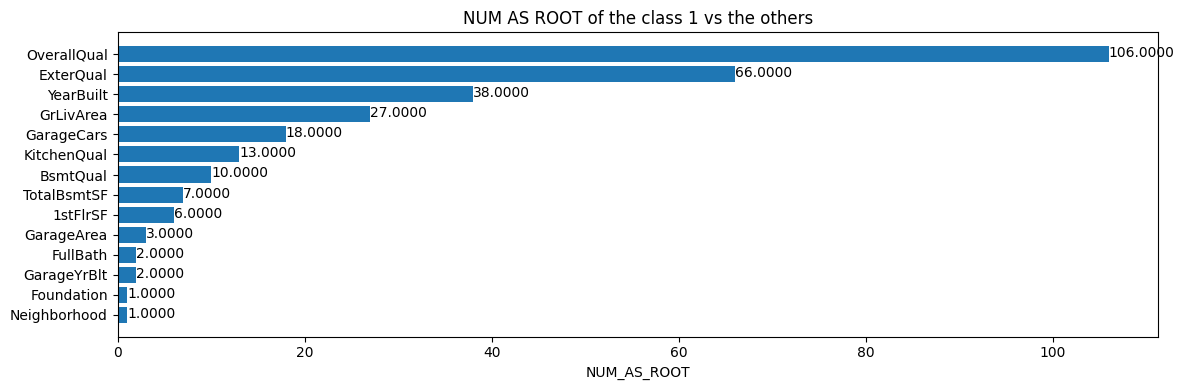

In [ ]:
plt.figure(figsize=(12, 4))

# Mean decrease in AUC of the class 1 vs the others.
variable_importance_metric = "NUM_AS_ROOT"
variable_importances = inspector.variable_importances()[variable_importance_metric]

# Extract the feature name and importance values.
#
# `variable_importances` is a list of <feature, importance> tuples.
feature_names = [vi[0].name for vi in variable_importances]
feature_importances = [vi[1] for vi in variable_importances]
# The feature are ordered in decreasing importance value.
feature_ranks = range(len(feature_names))

bar = plt.barh(feature_ranks, feature_importances, label=[str(x) for x in feature_ranks])
plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis()

# TODO: Replace with "plt.bar_label()" when available.
# Label each bar with values
for importance, patch in zip(feature_importances, bar.patches):
  plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{importance:.4f}", va="top")

plt.xlabel(variable_importance_metric)
plt.title("NUM AS ROOT of the class 1 vs the others")
plt.tight_layout()
plt.show()

In [ ]:
ids = test_data.pop('Id')

test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    test_data,
    task = tfdf.keras.Task.REGRESSION)

preds = best_rf_model.predict(test_ds)
output = pd.DataFrame({'Id': ids,
                       'SalePrice': preds.squeeze()})

output.head()

2/2 [==============================] - 1s 28ms/step


,Id,SalePrice
0,1461,126544.640625
1,1462,149223.437500
2,1463,180529.859375
3,1464,184448.140625
4,1465,204040.890625


In [ ]:
submission_df = pd.read_csv('/content/drive/MyDrive/758J Project/sample_submission.csv')
submission_df['SalePrice'] = best_rf_model.predict(test_ds)
submission_df.to_csv('/content/drive/MyDrive/758J Project/submission.csv', index=False)
submission_df.head()

2/2 [==============================] - 0s 30ms/step


,Id,SalePrice
0,1461,126544.640625
1,1462,149223.437500
2,1463,180529.859375
3,1464,184448.140625
4,1465,204040.890625
